In [799]:
from sklearn.model_selection import train_test_split # type: ignore
import opensmile
import librosa
import numpy as np
import pandas as pd
import os
import noisereduce as nr
from scipy.signal import butter, lfilter
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
from sklearn.ensemble import ExtraTreesClassifier # type: ignore
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report # type: ignore
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

In [800]:
# get test split
combined = pd.read_csv("combined.csv")
combined_x = combined.drop(columns=["emotion"])
combined_y = combined[["emotion"]]

le = LabelEncoder()
combined_y = le.fit_transform(combined_y["emotion"])
combined_y = pd.DataFrame(combined_y)
joblib.dump(le, "label_encoder_smile_wav2.pkl")

x_train, x_test, y_train, y_test = train_test_split(
    combined_x, combined_y,
    test_size=0.33,
    stratify=combined_y,
    random_state=42
)


x_train.to_csv("x_train_smile_wav2.csv", index=False)
x_test.to_csv("x_test_smile_wav2.csv", index=False)
y_train.to_csv("y_train_smile_wav2.csv", index=False)
y_test.to_csv("y_test_smile_wav2.csv", index=False)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).ravel().astype(int)
y_test = np.array(y_test).ravel().astype(int)

In [801]:
# 1) mask out your positive samples
mask_pos = (y_train == 2)
X_pos    = x_train[mask_pos]      # shape (n_pos, D)
print(x_train.shape)
print(X_pos.shape)
# 2) create one noisy copy of each positive vector
noise_level = 0.05
X_pos_aug   = X_pos + np.random.randn(*X_pos.shape) * noise_level
X_pos_aug = X_pos_aug[:X_pos_aug.shape[0] // 2] # reduce size to half of original
y_pos_aug   = np.full(len(X_pos_aug), 2, dtype=int)

# 3) stack them back onto your original training set
x_train_aug = np.vstack([x_train, X_pos_aug])      # now shape (N+n_pos, D)
print(x_train_aug.shape)
y_train_aug = np.concatenate([y_train, y_pos_aug]) # shape (N+n_pos,)
# 4) shuffle so the model doesn’t see all the augmented at once
x_train_aug, y_train_aug = shuffle(
    x_train_aug, y_train_aug, random_state=42
)

# Now replace your training arrays:
x_train = x_train_aug
y_train = y_train_aug

(1590, 204)
(385, 204)
(1782, 204)


In [802]:
# # 1) Find indices of all positive samples
# pos_idx = np.where(y_train == 2)[0]

# # 2) Randomly pair them (you can control how many you want)
# n_pos = len(pos_idx)
# # Here, we’ll make one new sample per existing pos sample:
# pairs = np.random.choice(pos_idx, size=(n_pos, 2), replace=True)

# # 3) Average each pair to make a new synthetic feature vector
# alpha = np.random.uniform(0.3, 0.7, size=(n_pos, 1))
# X_pos_aug = alpha * x_train[pairs[:,0]] + (1-alpha) * x_train[pairs[:,1]]
# y_pos_aug = np.full(n_pos, 2, dtype=int)

# # 4) Stack onto your original training set
# x_train_aug = np.vstack([x_train, X_pos_aug])
# y_train_aug = np.concatenate([y_train, y_pos_aug])

# # 5) Shuffle so the model sees them mixed
# x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug, random_state=42)

# # 6) Replace your train arrays and proceed as usual
# x_train = x_train_aug
# y_train = y_train_aug

In [803]:
import torch.nn as nn

class WV2PlusMLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        n_classes: int = 3,
        hidden1: int = 128,
        hidden2: int = 64,
        dropout1: float = 0.5,
        dropout2: float = 0.3,
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

In [804]:
tx_train = torch.tensor(x_train, dtype=torch.float32)
ty_train = torch.tensor(y_train, dtype=torch.long)
tx_test  = torch.tensor(x_test,  dtype=torch.float32)
ty_test  = torch.tensor(y_test,  dtype=torch.long)

In [805]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32

train_ds = TensorDataset(tx_train, ty_train)
test_ds  = TensorDataset(tx_test,  ty_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)


In [806]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# in_dim = X_train.shape[1]  (should be 63 + proj_dim if you projected)
model = WV2PlusMLP(
    in_dim    = x_train.shape[1],
    hidden1   = 128,
    hidden2   = 64,
    dropout1  = 0.5,
    dropout2  = 0.4
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,           # lower LR for stability
    weight_decay=1e-4  # L2 penalty to shrink weights
)

Using device: cpu


In [807]:
import torch.optim as optim



best_val_f1 = 0
patience    = 10
wait        = 0

for epoch in range(1, 100):
    # — Train —
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    # — Eval on train (optional) & val/test —
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_preds.append(logits.argmax(dim=1).cpu())
            all_labels.append(yb.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    report = classification_report(
        y_true, y_pred,
        target_names=["neg", "neu", "pos"],
        output_dict=True
    )
    val_f1 = report["pos"]["f1-score"]
    acc = report["accuracy"]
    print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f} — acc: {acc:.3f} — pos F1: {val_f1:.3f}")

    # — Simple early stopping on pos‐F1 —
    # if val_f1 > best_val_f1:
    #     best_val_f1 = val_f1
    #     wait = 0
    # else:
    #     wait += 1
    #     if wait >= patience:
    #         print(f"No improvement for {patience} epochs, stopping.")
    #         break


Epoch 01 — Loss: 1.0362 — acc: 0.533 — pos F1: 0.102
Epoch 02 — Loss: 0.9336 — acc: 0.547 — pos F1: 0.124
Epoch 03 — Loss: 0.8313 — acc: 0.570 — pos F1: 0.227
Epoch 04 — Loss: 0.8866 — acc: 0.585 — pos F1: 0.299
Epoch 05 — Loss: 0.9682 — acc: 0.603 — pos F1: 0.396
Epoch 06 — Loss: 1.0143 — acc: 0.612 — pos F1: 0.408
Epoch 07 — Loss: 0.9358 — acc: 0.622 — pos F1: 0.448
Epoch 08 — Loss: 0.7435 — acc: 0.628 — pos F1: 0.459
Epoch 09 — Loss: 0.8450 — acc: 0.631 — pos F1: 0.449
Epoch 10 — Loss: 0.9393 — acc: 0.644 — pos F1: 0.480
Epoch 11 — Loss: 0.6864 — acc: 0.656 — pos F1: 0.483
Epoch 12 — Loss: 0.8708 — acc: 0.659 — pos F1: 0.506
Epoch 13 — Loss: 0.7934 — acc: 0.667 — pos F1: 0.521
Epoch 14 — Loss: 0.8331 — acc: 0.672 — pos F1: 0.524
Epoch 15 — Loss: 0.7931 — acc: 0.667 — pos F1: 0.519
Epoch 16 — Loss: 0.7622 — acc: 0.666 — pos F1: 0.516
Epoch 17 — Loss: 0.8792 — acc: 0.662 — pos F1: 0.514
Epoch 18 — Loss: 0.7991 — acc: 0.667 — pos F1: 0.520
Epoch 19 — Loss: 0.7400 — acc: 0.666 — pos F1:

              precision    recall  f1-score   support

         neg       0.75      0.77      0.76       433
         neu       0.70      0.74      0.72       161
         pos       0.62      0.56      0.59       190

    accuracy                           0.71       784
   macro avg       0.69      0.69      0.69       784
weighted avg       0.71      0.71      0.71       784



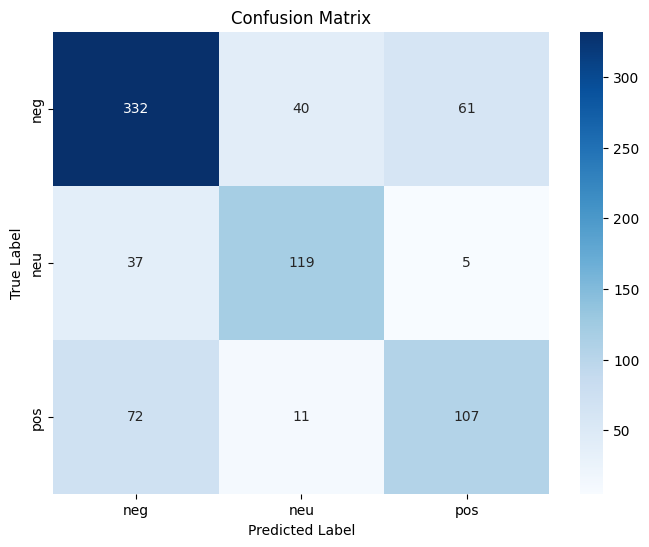

In [808]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(yb)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

print(classification_report(y_true, y_pred, target_names=["neg","neu","pos"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["neg","neu","pos"],
    yticklabels=["neg","neu","pos"]
    )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

         neg       0.79      0.84      0.81       879
         neu       0.78      0.82      0.80       326
         pos       0.81      0.70      0.75       577

    accuracy                           0.79      1782
   macro avg       0.79      0.79      0.79      1782
weighted avg       0.79      0.79      0.79      1782



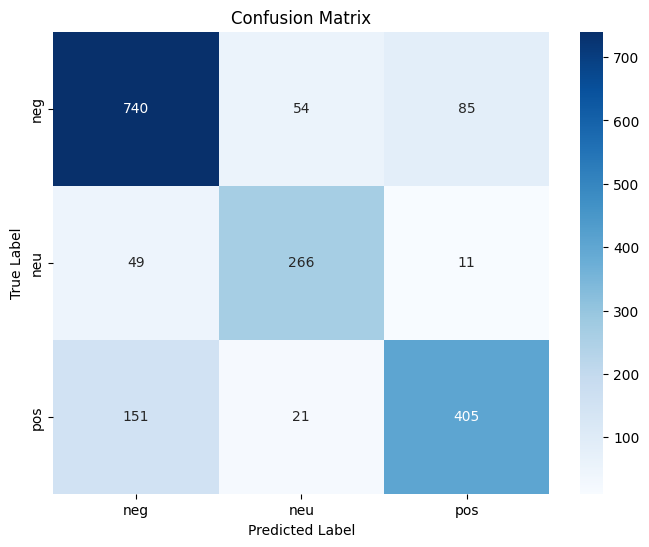

In [809]:
# Test for overfitting
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(yb)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

print(classification_report(y_true, y_pred, target_names=["neg","neu","pos"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["neg","neu","pos"],
    yticklabels=["neg","neu","pos"]
    )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()